# GridWorld Environment Playground

Interactive demos covering every feature of the environment:
movement, walls, rewards, keys, doors, key pairs, wrong-key penalties, Posner cueing, observations, and pre-built layouts.

Each section instantiates a fresh environment, walks through a sequence of actions, and visualises the result.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gridworld_env import GridWorldEnv
from gridworld_env.environment import Action
from gridworld_env.layout import parse_layout_string
from gridworld_env.objects import KeyColor

UP, DOWN, LEFT, RIGHT = Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT

# ── helpers ──

def render_env(env, ax, title=""):
    """Display the environment's built-in rgb_array render on a matplotlib axis."""
    frame = env.render()
    if frame is not None:
        ax.imshow(frame)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=10, pad=6)

def run(env, actions):
    """Execute a list of actions; return last step result."""
    result = None
    for a in actions:
        result = env.step(a)
    return result

def capture_frame(env, title=""):
    """Render the current state to an RGB numpy array (for video)."""
    fig, ax = plt.subplots(figsize=(4.5, 5.5))
    render_env(env, ax, title)
    plt.tight_layout()
    fig.canvas.draw()
    img = np.asarray(fig.canvas.buffer_rgba())[:, :, :3].copy()
    plt.close(fig)
    return img

## 1. Movement & Walls

The agent moves on a grid with `UP`, `DOWN`, `LEFT`, `RIGHT`. Walls block movement and return a collision penalty (`collision_reward`, default -0.1). Each step also incurs a small `step_reward` (default -0.01).

Wall collision reward: -0.11


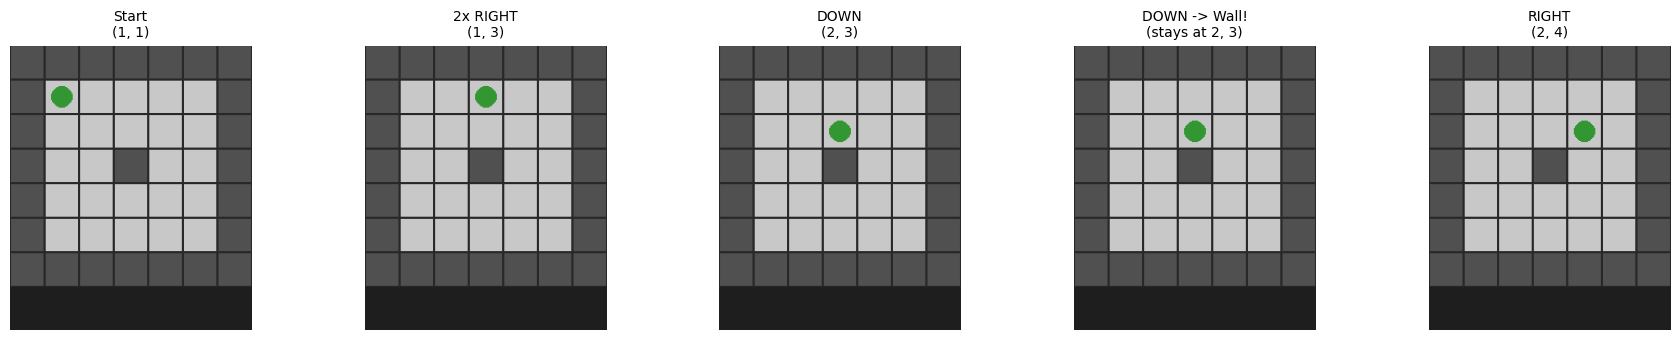

In [30]:
layout_basic = """
#######
#S....#
#.....#
#..#..#
#.....#
#.....#
#######
"""

env = GridWorldEnv(layout_basic, render_mode="rgb_array")
obs, info = env.reset()

fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))

render_env(env, axes[0], "Start\n(1, 1)")

run(env, [RIGHT, RIGHT])
render_env(env, axes[1], "2x RIGHT\n(1, 3)")

env.step(DOWN)
render_env(env, axes[2], "DOWN\n(2, 3)")

obs, reward, _, _, _ = env.step(DOWN)
render_env(env, axes[3], "DOWN -> Wall!\n(stays at 2, 3)")
print(f"Wall collision reward: {reward:.2f}")

env.step(RIGHT)
render_env(env, axes[4], "RIGHT\n(2, 4)")

plt.tight_layout(); plt.show()
env.close()

## 2. Collecting Rewards

Rewards (`G` or `R` in layouts) are collected automatically when the agent steps onto them. The episode terminates once all rewards are collected or destroyed.

Step reward returned: 0.99  (step_reward + reward_value)
Episode terminated:   True


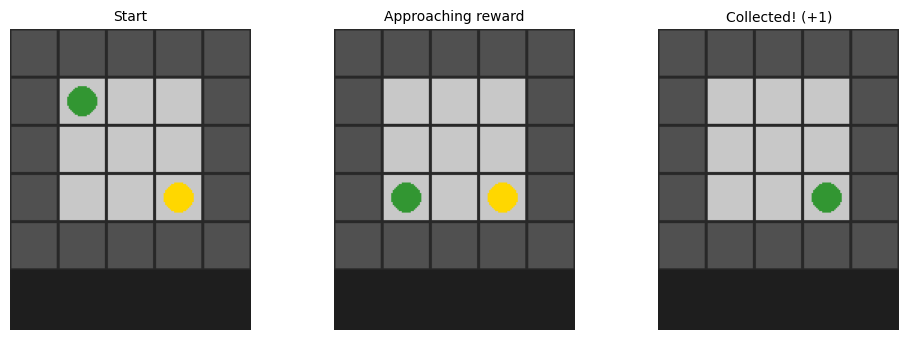

In [31]:
layout_reward = """
#####
#S..#
#...#
#..G#
#####
"""

env = GridWorldEnv(layout_reward, render_mode="rgb_array")
obs, info = env.reset()

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

render_env(env, axes[0], "Start")

run(env, [DOWN, DOWN])
render_env(env, axes[1], "Approaching reward")

obs, reward, terminated, _, info = run(env, [RIGHT, RIGHT])
render_env(env, axes[2], f"Collected! (+{info['collected_rewards']:.0f})")

print(f"Step reward returned: {reward:.2f}  (step_reward + reward_value)")
print(f"Episode terminated:   {terminated}")

plt.tight_layout(); plt.show()
env.close()

## 3. Keys, Doors & Key Pairs

- **Keys** (`r`/`b`) are collected automatically when the agent steps on them. The agent can hold one key at a time.
- **Key pairs**: two adjacent keys of different colours are linked. Collecting one makes the other disappear, forcing a choice.
- **Doors** (`D`) block movement until the agent holds any key. The door opens and the key is consumed.
- Each door has a *correct* key colour (set in the layout config). Collecting the wrong key from a key pair **immediately destroys** the reward behind the associated door — the agent doesn't need to reach the door first.

Held key: red
Episode terminated: True


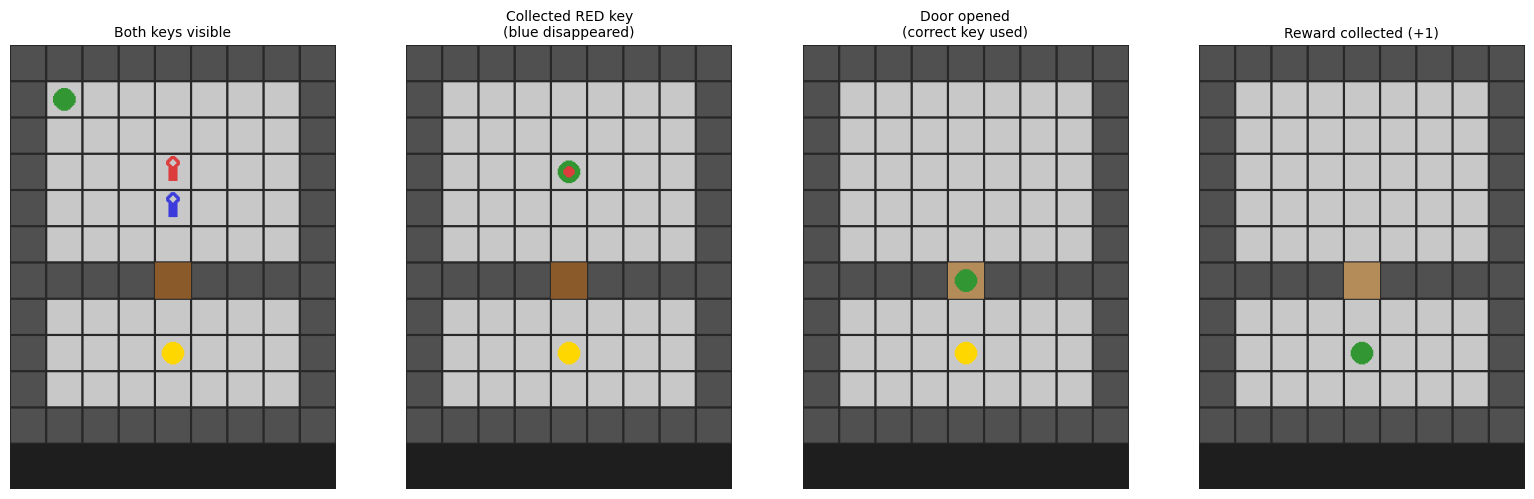

In [32]:
layout_room = """
#########
#S......#
#.......#
#...r...#
#...b...#
#.......#
####D####
#.......#
#...G...#
#.......#
#########
"""
config_room = {
    "door_colors": {"6,4": "red"},
    "key_pairs": [{"positions": ["3,4", "4,4"], "room_id": 0}],
    "protected_rewards": {"6,4": ["8,4"]},
}

parsed_room = parse_layout_string(layout_room, config_room)
env = GridWorldEnv(parsed_room, render_mode="rgb_array")
obs, info = env.reset()

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

# 1) Both keys visible
render_env(env, axes[0], "Both keys visible")

# 2) Collect RED key (correct) at (3,4)
run(env, [DOWN, DOWN, RIGHT, RIGHT, RIGHT])
render_env(env, axes[1], "Collected RED key\n(blue disappeared)")
print(f"Held key: {env.held_key}")

# 3) Open door at (6,4) with correct key
run(env, [DOWN, DOWN, DOWN])
render_env(env, axes[2], "Door opened\n(correct key used)")

# 4) Collect reward at (8,4)
obs, _, terminated, _, info = run(env, [DOWN, DOWN])
render_env(env, axes[3], f"Reward collected (+{info['collected_rewards']:.0f})")
print(f"Episode terminated: {terminated}")

plt.tight_layout(); plt.show()
env.close()

## 4. Wrong Key Penalty

Collecting the *wrong* key from a key pair immediately **destroys** any rewards protected by the associated door — the agent doesn't even need to reach the door. The episode terminates as soon as all rewards are resolved (collected or destroyed).

In [ ]:
env = GridWorldEnv(parsed_room, render_mode="rgb_array")
obs, info = env.reset()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

render_env(env, axes[0], "Both keys visible\n(reward behind door)")

# Collect BLUE key (wrong!) at (4,4) — reward destroyed immediately on collection
obs, _, terminated, _, info = run(env, [DOWN, DOWN, DOWN, RIGHT, RIGHT, RIGHT])
render_env(env, axes[1], "Collected BLUE key (wrong!)\nReward DESTROYED immediately")
print(f"Held key: {env.held_key}")
print(f"Episode terminated: {terminated}")
print(f"Destroyed rewards:  {info['destroyed_rewards']:.1f}")

plt.tight_layout(); plt.show()
env.close()

## 5. Posner Cueing Mode

When `posner_mode=True`, the environment generates a *cue* at the start of each episode indicating which key colour to collect. The cue is correct with probability `posner_validity` (default 0.8).

The cue is included in both the observation vector and the `info` dict.

In [ ]:
env = GridWorldEnv(
    parsed_room,
    posner_mode=True,
    posner_validity=0.8,
    render_mode="rgb_array",
    debug_cues=True,
)

print("Posner cue over 10 trials (validity=0.8):\n")
valid_count = 0
valid_seed = invalid_seed = None
for i in range(10):
    obs, info = env.reset(seed=i)
    valid = info["posner_cue_valid"]
    valid_count += valid
    if valid and valid_seed is None:
        valid_seed = i
    if not valid and invalid_seed is None:
        invalid_seed = i
    print(f"  Trial {i+1:2d}:  cue = {info['posner_cue']:4s}   valid = {valid}")

print(f"\nValid: {valid_count}/10  (expected ~80%)")

# ── Visualise: what happens when the agent follows the cue ──

fig, axes = plt.subplots(2, 2, figsize=(9, 10))

# Row 1: Valid cue — agent follows cue, picks correct key, reward collected
obs, info = env.reset(seed=valid_seed)
cue = info["posner_cue"]
render_env(env, axes[0, 0], f"Valid cue trial\nCue: {cue.upper()} (correct!)")

# Follow cue → pick red key (correct key for this layout)
run(env, [DOWN, DOWN, RIGHT, RIGHT, RIGHT])        # collect red key at (3,4)
run(env, [DOWN, DOWN, DOWN, DOWN, DOWN])            # through door, collect reward
render_env(env, axes[0, 1], f"Agent followed cue\nReward collected!")

# Row 2: Invalid cue — agent follows cue, picks wrong key, reward destroyed immediately
if invalid_seed is not None:
    obs, info = env.reset(seed=invalid_seed)
    cue = info["posner_cue"]
    render_env(env, axes[1, 0], f"Invalid cue trial\nCue: {cue.upper()} (wrong!)")

    # Follow cue → pick blue key (wrong key) — reward destroyed on collection
    run(env, [DOWN, DOWN, DOWN, RIGHT, RIGHT, RIGHT])  # collect blue key at (4,4)
    render_env(env, axes[1, 1], f"Agent followed cue\nReward destroyed instantly!")
else:
    for ax in axes[1]:
        ax.set_visible(False)

plt.tight_layout(); plt.show()
env.close()

## 6. Multi-Feature Posner Cues

The cue can be extended to a vector of `posner_num_features` elements. Only the feature at `posner_cue_index` carries the true signal; the rest are random distractors.

4 cue features, true cue at index 2 (shown in brackets):

  Trial 1:   blue   blue  [red]  red    valid = True
  Trial 2:   blue   blue  [blue]  blue    valid = False
  Trial 3:   red   blue  [red]  red    valid = True
  Trial 4:   red   blue  [red]  red    valid = True
  Trial 5:   blue   blue  [blue]  blue    valid = False


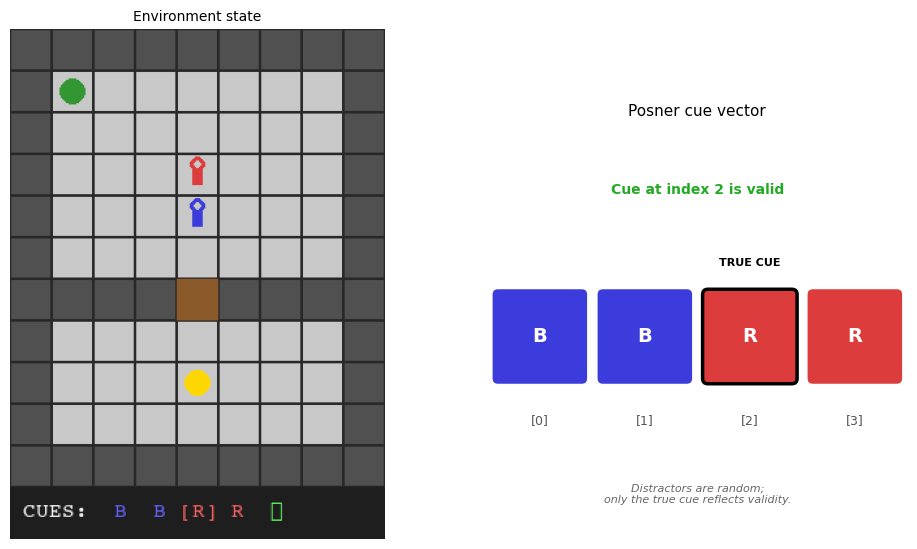

In [35]:
env = GridWorldEnv(
    parsed_room,
    posner_mode=True,
    posner_validity=0.8,
    posner_num_features=4,
    posner_cue_index=2,
    render_mode="rgb_array",
    debug_cues=True,
)

print("4 cue features, true cue at index 2 (shown in brackets):\n")
for i in range(5):
    obs, info = env.reset(seed=i * 7)
    cues = info["posner_cues"]
    idx = info["posner_cue_index"]
    parts = [f"[{c}]" if j == idx else f" {c} " for j, c in enumerate(cues)]
    print(f"  Trial {i+1}:  {' '.join(parts)}   valid = {info['posner_cue_valid']}")

# ── Visualise: environment state + cue vector ──

obs, info = env.reset(seed=0)
cues = info["posner_cues"]
idx = info["posner_cue_index"]
valid = info["posner_cue_valid"]

fig = plt.figure(figsize=(10, 6))

# Left: environment state
ax_env = fig.add_axes([0.02, 0.05, 0.48, 0.85])
render_env(env, ax_env, "Environment state")

# Right: cue vector diagram
ax_cue = fig.add_axes([0.55, 0.05, 0.42, 0.85])
ax_cue.set_xlim(-0.5, len(cues) - 0.5)
ax_cue.set_ylim(-1, 2)
ax_cue.set_aspect("equal")
ax_cue.set_xticks([])
ax_cue.set_yticks([])
ax_cue.set_title("Posner cue vector", fontsize=11, pad=8)

for i, cue in enumerate(cues):
    color = "#DC3C3C" if str(cue) == "red" else "#3C3CDC"
    label = "R" if str(cue) == "red" else "B"
    edge = "black" if i == idx else "none"
    lw = 2.5 if i == idx else 0

    rect = mpatches.FancyBboxPatch(
        (i - 0.4, -0.4), 0.8, 0.8,
        boxstyle="round,pad=0.05", facecolor=color,
        edgecolor=edge, linewidth=lw)
    ax_cue.add_patch(rect)
    ax_cue.text(i, 0, label, ha="center", va="center",
                fontsize=14, fontweight="bold", color="white")

    # Index label below
    ax_cue.text(i, -0.8, f"[{i}]", ha="center", va="center", fontsize=9, color="#555")
    if i == idx:
        ax_cue.text(i, 0.7, "TRUE CUE", ha="center", va="center",
                    fontsize=8, fontweight="bold", color="black")

# Validity annotation
marker = "valid" if valid else "invalid"
marker_color = "#22AA22" if valid else "#CC3333"
ax_cue.text(len(cues) / 2 - 0.5, 1.4, f"Cue at index {idx} is {marker}",
            ha="center", va="center", fontsize=10, fontweight="bold", color=marker_color)
ax_cue.text(len(cues) / 2 - 0.5, -1.5,
            "Distractors are random;\nonly the true cue reflects validity.",
            ha="center", va="center", fontsize=8, color="#666", style="italic")

ax_cue.axis("off")
plt.show()
env.close()

## 7. Observation Spaces

Two observation formats are available:
- `flatten_obs=True` (default): a 1-D float32 array (one-hot grid + agent position + held key + Posner cue).
- `flatten_obs=False`: a dict with `grid`, `agent_pos`, `held_key`, `posner_cue`.

In [36]:
# ── Flat ──
env_flat = GridWorldEnv(layout_room, flatten_obs=True)
obs, _ = env_flat.reset()

h, w = env_flat._layout.height, env_flat._layout.width
n_types = 9
grid_size = h * w * n_types

print("=== Flat observation (flatten_obs=True) ===")
print(f"Shape: {obs.shape}   dtype: {obs.dtype}")
print(f"\nBreakdown ({obs.shape[0]} values):")
print(f"  Grid one-hot:    {h} x {w} x {n_types} = {grid_size}")
print(f"  Agent position:  2  (normalised to [0,1])")
print(f"  Held key:        3  (one-hot: none / red / blue)")
print(f"  Posner cue:      3  (one-hot: none / red / blue)")
print(f"  Total:           {grid_size + 8}")
env_flat.close()

print()

# ── Dict ──
env_dict = GridWorldEnv(layout_room, flatten_obs=False)
obs, _ = env_dict.reset()

print("=== Dict observation (flatten_obs=False) ===")
for k, v in obs.items():
    if isinstance(v, np.ndarray):
        print(f"  '{k}':  shape={v.shape}  dtype={v.dtype}")
    else:
        print(f"  '{k}':  {v}")

print("\nGrid cell types:")
print("  0=EMPTY  1=WALL  2=AGENT  3=KEY_RED  4=KEY_BLUE")
print("  5=DOOR_CLOSED  6=DOOR_OPEN  7=REWARD  8=REWARD_DESTROYED")
env_dict.close()


=== Flat observation (flatten_obs=True) ===
Shape: (899,)   dtype: float32

Breakdown (899 values):
  Grid one-hot:    11 x 9 x 9 = 891
  Agent position:  2  (normalised to [0,1])
  Held key:        3  (one-hot: none / red / blue)
  Posner cue:      3  (one-hot: none / red / blue)
  Total:           899

=== Dict observation (flatten_obs=False) ===
  'grid':  shape=(11, 9)  dtype=int32
  'agent_pos':  shape=(2,)  dtype=int32
  'held_key':  0
  'posner_cue':  shape=(1,)  dtype=int32

Grid cell types:
  0=EMPTY  1=WALL  2=AGENT  3=KEY_RED  4=KEY_BLUE
  5=DOOR_CLOSED  6=DOOR_OPEN  7=REWARD  8=REWARD_DESTROYED


## 8. Pre-built Layouts

The package ships with several layout files (`.txt` + `.json` config). Pass the file path directly to `GridWorldEnv`.

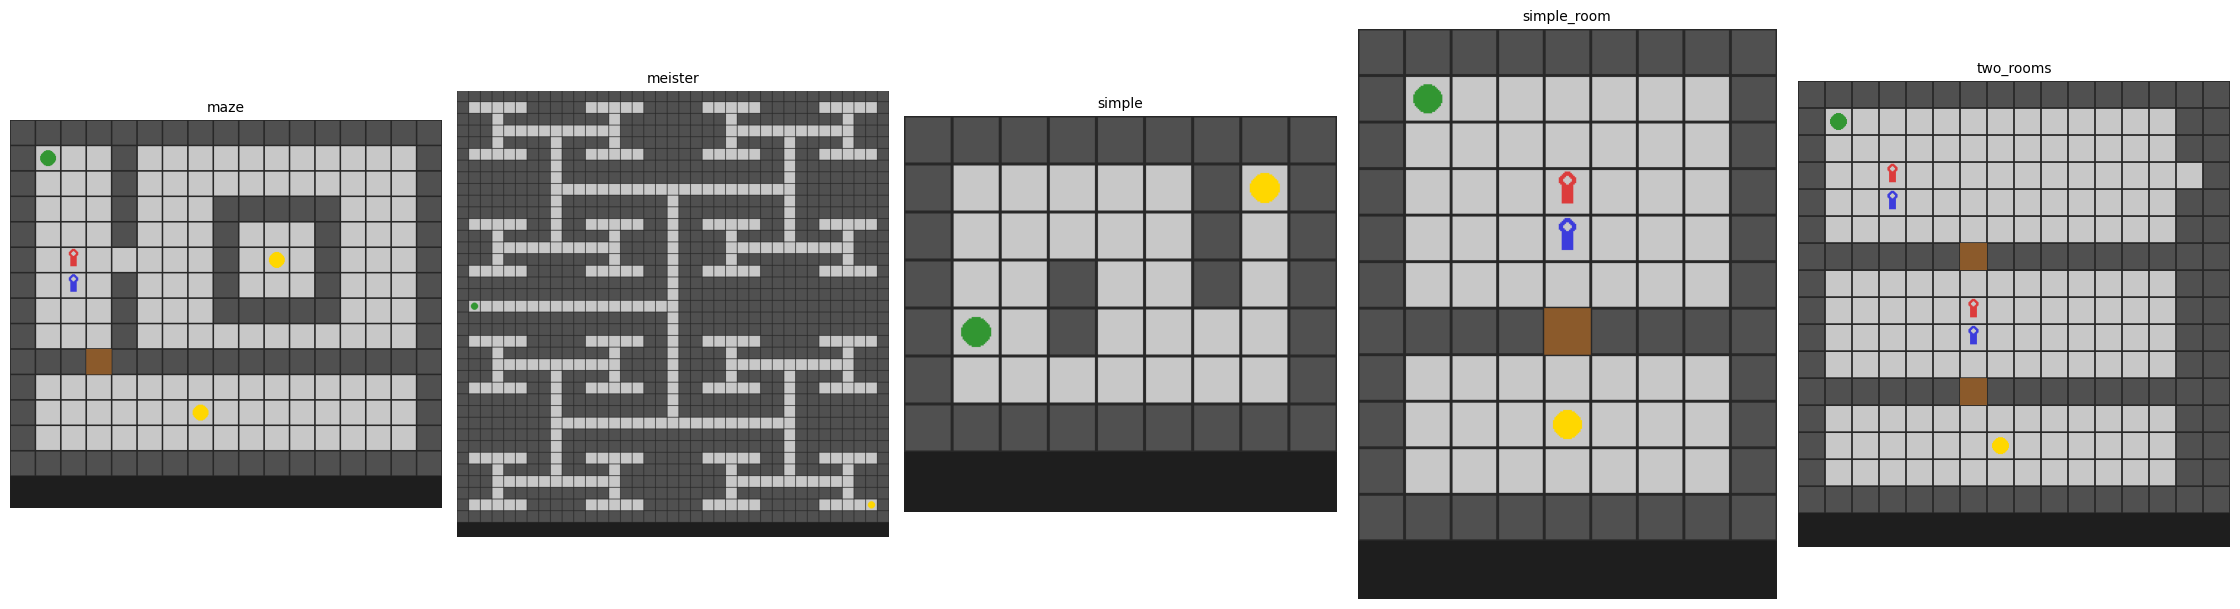

Layout                Size  Keys  Doors  Rewards
--------------------------------------------------
maze                14x17      4      1        2
meister             37x37      0      0        1
simple               7x9       0      0        1
simple_room         11x9       4      1        1
two_rooms           16x16      8      2        1


In [37]:
import os, gridworld_env

layouts_dir = os.path.join(os.path.dirname(gridworld_env.__file__), "layouts")
layout_files = sorted(f for f in os.listdir(layouts_dir) if f.endswith(".txt"))

fig, axes = plt.subplots(1, len(layout_files),
                         figsize=(4.5 * len(layout_files), 6))
if len(layout_files) == 1:
    axes = [axes]

for ax, lf in zip(axes, layout_files):
    path = os.path.join(layouts_dir, lf)
    env = GridWorldEnv(path, render_mode="rgb_array")
    env.reset()
    render_env(env, ax, lf.replace(".txt", ""))
    env.close()

plt.tight_layout(); plt.show()

# Summary table
print(f"{'Layout':<18} {'Size':>7}  {'Keys':>4}  {'Doors':>5}  {'Rewards':>7}")
print("-" * 50)
for lf in layout_files:
    path = os.path.join(layouts_dir, lf)
    env = GridWorldEnv(path); env.reset()
    lo = env._layout
    nk = len(lo.keys) + sum(len(kp.keys) for kp in lo.key_pairs)
    print(f"{lf.replace('.txt',''):<18} {lo.height:>3}x{lo.width:<3}  {nk:>4}  {len(lo.doors):>5}  {len(lo.rewards):>7}")
    env.close()

## 9. Random Agent Rollout

Run a random-action agent over many episodes to see baseline performance, then visualise a single episode.

In [38]:
env = GridWorldEnv(parsed_room, max_steps=200)

n_episodes = 500
stats = {"steps": [], "reward": [], "collected": [], "destroyed": []}

for ep in range(n_episodes):
    obs, info = env.reset(seed=ep)
    total = 0.0
    done = False
    while not done:
        obs, r, term, trunc, info = env.step(env.action_space.sample())
        total += r
        done = term or trunc
    stats["steps"].append(info["steps"])
    stats["reward"].append(total)
    stats["collected"].append(info["collected_rewards"])
    stats["destroyed"].append(info["destroyed_rewards"])

print(f"Random agent | {n_episodes} episodes | max_steps=200\n")
print(f"  Avg steps:        {np.mean(stats['steps']):6.1f}")
print(f"  Avg total reward: {np.mean(stats['reward']):6.2f}")
print(f"  Reward collected: {sum(c > 0 for c in stats['collected']):>4}/{n_episodes}")
print(f"  Reward destroyed: {sum(d > 0 for d in stats['destroyed']):>4}/{n_episodes}")
print(f"  Timed out:        {sum(s >= 200 for s in stats['steps']):>4}/{n_episodes}")
env.close()

Random agent | 500 episodes | max_steps=200

  Avg steps:         162.9
  Avg total reward:  -4.29
  Reward collected:  104/500
  Reward destroyed:   98/500
  Timed out:         300/500


In [39]:
from matplotlib.animation import FFMpegWriter
from IPython.display import Video

# Run one episode, capturing a frame at every step
env = GridWorldEnv(parsed_room, max_steps=200, render_mode="rgb_array")
obs, info = env.reset(seed=42)

frames = []
total_reward = 0.0
step_num = 0

key_label = str(env.held_key) if env.held_key else "none"
frames.append(capture_frame(env, f"Step {step_num}  |  Key: {key_label}  |  R: {total_reward:+.2f}"))

done = False
while not done:
    obs, r, term, trunc, info = env.step(env.action_space.sample())
    total_reward += r
    step_num += 1
    done = term or trunc
    key_label = str(env.held_key) if env.held_key else "none"
    status = ""
    if term:
        status = "  DONE"
    frames.append(capture_frame(
        env,
        f"Step {step_num}  |  Key: {key_label}  |  R: {total_reward:+.2f}{status}"))

# Write MP4 using matplotlib + ffmpeg
fig_vid, ax_vid = plt.subplots(figsize=(4.5, 5.5))
ax_vid.axis("off")
im = ax_vid.imshow(frames[0])
plt.tight_layout()

mp4_path = "random_agent_episode.mp4"
writer = FFMpegWriter(fps=10)
with writer.saving(fig_vid, mp4_path, dpi=100):
    for frame in frames:
        im.set_data(frame)
        writer.grab_frame()
plt.close(fig_vid)

print(f"Saved {mp4_path}:  {len(frames)} frames,  {step_num} steps")
print(f"  Total reward:  {total_reward:.2f}")
print(f"  Collected:     {info['collected_rewards']:.0f}")
print(f"  Destroyed:     {info['destroyed_rewards']:.0f}")
env.close()

Video(mp4_path, embed=True, width=450)

Saved random_agent_episode.mp4:  201 frames,  200 steps
  Total reward:  -6.10
  Collected:     0
  Destroyed:     0
